### MACHINE TRANSLATION MODEL

Here I am developing 4 machine translation models 
1) sequence to sequence model
2) sequence to sequence model with Attention
3) Extending model 2 by stackinh up encoder and decoder layers
4) Extending model 2 by using pretrained GloVE Embeddings

In the end I compare the performance of these models

In [36]:
## DATA PREPARATION
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from google.colab import drive
drive.mount('/content/drive')
file_path = "/content/drive/MyDrive"



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
SOS_token = 0;
EOS_token = 1;


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1




In [3]:
#coverting unicode to ascii to simplify and the trim the punctuation and change everything to lower case
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [4]:
import pandas as pd
def readCSV(csv_file):
    print("Reading CSV file...")
    # Read the CSV file
    df = pd.read_csv(csv_file)

    # Extract Ingredients and Recipe columns
    ingredients = df['Ingredients'].tolist()
    recipes = df['Recipe'].tolist()

    return ingredients, recipes



def readLangs(Ingredients, Recipe, reverse=False):
    print("Reading lines...")
    Lines = readCSV('your_csv_file.csv').strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]


    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_ingredients = Lang(Ingredients)
        output_recipe = Lang(Recipe)
    else:
        input_ingredients = Lang(Ingredients)
        output_recipe = Lang(Recipe)

    return input_ingredients, output_recipe, pairs

In [5]:
MAX_LENGTH = 150

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH \


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [130]:
def prepareData(Ingredients, Recipe, reverse=False):
    pairs = [(str(ing),str(rec)) for ing,rec in zip(ingredients, recipes)]
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    input_ingredients= Lang('Ingredients')
    output_recipe=Lang('Recipe')
    print("Counting words...")
    for pair in pairs:
        input_ingredients.addSentence(pair[0])
        output_recipe.addSentence(pair[1])
    print("Counted words:")
    print(input_ingredients.name, input_ingredients.n_words)
    print(output_recipe.name, output_recipe.n_words)
    return input_ingredients, output_recipe, pairs

ingredients, recipes= readCSV('/content/drive/MyDrive/train.csv')
input_ingredients, output_recipe, pairs = prepareData(ingredients, recipes , True)
test_ingredients, test_recipes= readCSV('/content/drive/MyDrive/test.csv')
input_test_ingredients, output_test_recipe, test_pairs = prepareData(test_ingredients, test_recipes , True)
val_ingredients, val_recipes= readCSV('/content/drive/MyDrive/dev.csv')
input_val_ingredients, output_val_recipe, val_pairs = prepareData(val_ingredients, val_recipes , True)
print(random.choice(pairs))
print(random.choice(test_pairs))
print(random.choice(val_pairs))

Reading CSV file...
Read 101340 sentence pairs
Trimmed to 79721 sentence pairs
Counting words...
Counted words:
Ingredients 107776
Recipe 35099
Reading CSV file...
Read 101340 sentence pairs
Trimmed to 79721 sentence pairs
Counting words...
Counted words:
Ingredients 107776
Recipe 35099
Reading CSV file...
Read 101340 sentence pairs
Trimmed to 79721 sentence pairs
Counting words...
Counted words:
Ingredients 107776
Recipe 35099
('4    thick slices white bread\t3    eggs\t2 tb milk (optional)\ttomato or brown\tsauce, to taste\tsalt and pepper\tbutter for frying', 'whisk together the eggs , milk -lrb- if required -rrb- , sauce , salt and pepper . cut the slices of bread into quarters . soak each piece of bread in the egg mixture and coat well . heat a little butter in a large frying pan , and fry the soaked bread until golden brown , turning over once . serve with crisply fried bacon for breakfast , or as a snack . ')
('1 lb hamburger\t1 md onion -- chopped\t1 sm green pepper -- chopped\

## Implementation of Seq2Seq model

The encoder

In [8]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.lstm(output, hidden)
        return output, hidden

    def initHidden(self):
        return (torch.zeros(1, 1, self.hidden_size, device=device),torch.zeros(1, 1, self.hidden_size, device=device))

The decoder

In [9]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.lstm(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return (torch.zeros(1, 1, self.hidden_size, device=device),torch.zeros(1, 1, self.hidden_size, device=device))

Preparing training data and training the model

In [117]:



def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_ingredients, pair[0])
    target_tensor = tensorFromSentence(output_recipe, pair[1])
    return (input_tensor, target_tensor)

def indexesFromSentence(lang, sentence):
    return [lang.word2index.get(word, UNK_token) for word in sentence.split(' ')]





In [11]:
teacher_forcing_ratio = 1


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length


In [12]:
def validation(input_tensor, target_tensor,encoder, decoder, criterion, max_length=MAX_LENGTH):

    with torch.no_grad():
            encoder_hidden = encoder.initHidden()
            input_length = input_tensor.size(0)
            target_length = target_tensor.size(0)

            encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

            loss = 0

            for ei in range(input_length):
                encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
                encoder_outputs[ei] = encoder_output[0, 0]

            decoder_input = torch.tensor([[SOS_token]], device=device)
            decoder_hidden = encoder_hidden

            for di in range(target_length):
                decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
                topv, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze().detach()

                loss += criterion(decoder_output, target_tensor[di])
                if decoder_input.item() == EOS_token:
                    break



    return loss.item() / target_length


In [13]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)



def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [14]:
def trainIters(encoder, decoder, n_iters, print_every=1000, save_every=1000, plot_every=1000, val_every=5000, learning_rate=0.01, validation_pairs=None, patience=3, val_subset_size=10000):
    start = time.time()
    train_losses = []
    val_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every
    best_loss = float('inf')
    no_improvement = 0
    checkpoints = []
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()
    plot_losses=[]
    training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(n_iters)]
    if validation_pairs is not None:
        val_pairs = [tensorsFromPair(pair) for pair in random.sample(validation_pairs, min(val_subset_size,len(validation_pairs)))]


    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss
        val_loss = 0
        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            train_losses.append(print_loss_avg)
            if validation_pairs is not None and iter % val_every == 0:
                encoder.eval()
                decoder.eval()


                for val_pair in val_pairs:
                  val_input_tensor = val_pair[0]
                  val_target_tensor = val_pair[1]
                  val_loss += validation(val_input_tensor, val_target_tensor, encoder, decoder, criterion)
                val_loss /= len(val_pairs)
                val_losses.append(val_loss)
                encoder.train()
                decoder.train()
                print('%s (%d %d%%) Training Loss %.4f ; Validation Loss: %.4f' % (timeSince(start, iter / n_iters),
                                                                                  iter, iter / n_iters * 100, print_loss_avg, val_loss))
            else:
                print('%s (%d %d%%) Training Loss %.4f' % (timeSince(start, iter / n_iters),
                                                            iter, iter / n_iters * 100, print_loss_avg))


        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

        if iter % save_every == 0:
            save_checkpoint(encoder, decoder, encoder_optimizer, decoder_optimizer, iter // save_every, train_losses, val_losses, '/content/drive/MyDrive/Colab Notebooks/checkpoint_50000.pt')

        if validation_pairs is not None and iter % val_every == 0:
            if val_loss < best_loss:
                best_loss = val_loss
                no_improvement = 0
            else:
                no_improvement += 1
                if no_improvement >= patience:
                    print("Early stopping after no improvement for %d iterations." % patience)
                    break

    return(train_losses, val_losses, val_every)


In [44]:
def save_checkpoint(encoder, decoder, encoder_optimizer, decoder_optimizer, epoch, train_losses, val_losses, filename):
    checkpoint = {
        'encoder_state_dict': encoder.state_dict(),
        'decoder_state_dict': decoder.state_dict(),
        'encoder_optimizer_state_dict': encoder_optimizer.state_dict(),
        'decoder_optimizer_state_dict': decoder_optimizer.state_dict(),
        'epoch': epoch,
        'train_losses': train_losses,
        'val_losses': val_losses
    }
    torch.save(checkpoint, filename)

def load_checkpoint(encoder, decoder, encoder_optimizer, decoder_optimizer, filename):
    checkpoint = torch.load(filename)
    encoder.load_state_dict(checkpoint['encoder_state_dict'])
    decoder.load_state_dict(checkpoint['decoder_state_dict'])
    encoder_optimizer.load_state_dict(checkpoint['encoder_optimizer_state_dict'])
    decoder_optimizer.load_state_dict(checkpoint['decoder_optimizer_state_dict'])
    epoch = checkpoint['epoch']
    train_losses = checkpoint['train_losses']
    val_losses = checkpoint['val_losses']
    return encoder, decoder, encoder_optimizer, decoder_optimizer, epoch, train_losses, val_losses

In [16]:

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def showPlot(train_losses, val_losses,val_every, plot_every):
    plt.figure()
    loc = ticker.MultipleLocator(base=0.5)
    plt.gca().yaxis.set_major_locator(loc)
    train_epochs = range(plot_every, len(train_losses)*plot_every + 1,plot_every)
    val_epochs=range(val_every, val_every*len(val_losses)+1,val_every)
    plt.plot(train_epochs, train_losses, label='Training Loss')
    if val_losses:
        plt.plot(val_epochs, val_losses, label='Validation Loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

In [17]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_ingredients, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_recipe.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words

In [18]:
def evaluateRandomly(encoder, decoder, n=10, save_path=None):
    generated_recipes=[]
    test_recipes=[]
    for i in range(n):
        pair = random.choice(test_pairs)
        print('>', pair[0])
        print('=', pair[1])#reference recipe
        output_words= evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence) #generated recipe
        generated_recipes.append(output_sentence)
        test_recipes.append(pair[1])
        print('')
        if save_path:
          data={'Test recipe':test_recipes, 'Generated recipe':generated_recipes}
          df=pd.DataFrame(data)
          df.to_csv(save_path,index=False)

In [ ]:
hidden_size = 256
encoder1 = EncoderRNN(input_ingredients.n_words, hidden_size).to(device)
decoder1 = DecoderRNN(hidden_size, output_recipe.n_words).to(device)

train_losses, val_losses, val_every=trainIters(encoder1, decoder1, 50000, print_every=1000,validation_pairs=val_pairs, patience=3)


1m 59s (- 97m 48s) (1000 2%) Training Loss 5.3535
4m 0s (- 96m 13s) (2000 4%) Training Loss 4.7628
5m 56s (- 93m 1s) (3000 6%) Training Loss 4.6039
7m 50s (- 90m 7s) (4000 8%) Training Loss 4.5998
15m 44s (- 141m 40s) (5000 10%) Training Loss 4.5102 ; Validation Loss: 5.7730
17m 38s (- 129m 23s) (6000 12%) Training Loss 4.5109
19m 32s (- 120m 5s) (7000 14%) Training Loss 4.5451
21m 28s (- 112m 42s) (8000 16%) Training Loss 4.4580
23m 21s (- 106m 26s) (9000 18%) Training Loss 4.3623
29m 53s (- 119m 34s) (10000 20%) Training Loss 4.4431 ; Validation Loss: 4.6280
31m 47s (- 112m 42s) (11000 22%) Training Loss 4.3874
33m 42s (- 106m 45s) (12000 24%) Training Loss 4.4545
35m 35s (- 101m 19s) (13000 26%) Training Loss 4.3519
37m 29s (- 96m 25s) (14000 28%) Training Loss 4.4140
43m 54s (- 102m 28s) (15000 30%) Training Loss 4.4410 ; Validation Loss: 4.8315
45m 48s (- 97m 20s) (16000 32%) Training Loss 4.4758
47m 42s (- 92m 35s) (17000 34%) Training Loss 4.4352
49m 35s (- 88m 9s) (18000 36%) T

In [ ]:
hidden_size=256
checkpoint_path = '/content/drive/MyDrive/Colab Notebooks/checkpoint_50000.pt'
encoder1 = EncoderRNN(input_ingredients.n_words, hidden_size).to(device)
decoder1 = DecoderRNN(hidden_size, output_recipe.n_words).to(device)
encoder_optimizer = optim.Adam(encoder1.parameters(), lr=0.01)
decoder_optimizer = optim.Adam(decoder1.parameters(), lr=0.01)


encoder, decoder, encoder_optimizer, decoder_optimizer, epoch, train_losses, val_losses = load_checkpoint(
    encoder1, decoder1, encoder_optimizer, decoder_optimizer, checkpoint_path
)


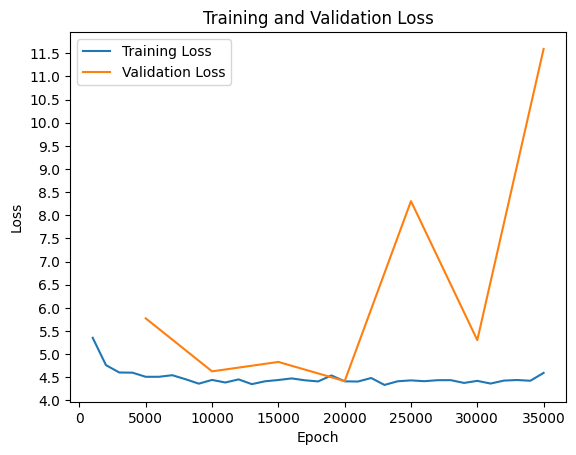

In [ ]:
showPlot(train_losses, val_losses, val_every=5000, plot_every=1000)

In [ ]:
evaluateRandomly(encoder1, decoder1, save_path='/content/drive/MyDrive/gen_vs_test_seq2seq.csv')

> 2 ts whole cumin seeds	4 ea whole cloves	3/4 ts black cardamom seeds	1/2 ts whole black peppercorns	1/4 ts whole allspice	1 ts fenugreek seeds	1/2 ts whole coriander seeds	10 sm dried red chilies	1/2 ts grated ginger	1/4 ts turmeric	1 ts salt	2 1/2 tb sweet hungarian paprika	1/8 ts cinnamon	1/8 ts ground cloves
= in a small frying pan , on a low heat , toast cumin , cloves , cardamom , peppercorns , allspice , fenugreek & corainder for about 2 minutes , stirring constantly . remove from heat & cool for 5 minutes . discard stems from chilies . in a spice grinder or with a mortar & pestle , finely grind together the toasted spices & chilies . mix in remaining ingredients . store in refrigerator in a well sealed jar . 
< in a large bowl .  <EOS>

> 1 c  homemade mayonnaise	1    poblano pepper, roasted, eeled, seeded, small diced	1/2 c  sweet corn, blanched	1 ts minced garlic	1/4 c  buttermilk	salt and pepper
= in a mixing bowl , combine all the ingredients together . mix until fully inc

### Implementation of Seq2Seq model with attention

In [19]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)

        self.dropout = nn.Dropout(self.dropout_p)
        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size*2, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        lstm_output, hidden = self.lstm(embedded, hidden)

        # Calculate attention weights and apply to encoder outputs
        attn_weights = F.softmax(torch.bmm(lstm_output.transpose(0, 1), encoder_outputs.unsqueeze(0).transpose(1, 2)), dim=-1)
        attn_output = torch.bmm(attn_weights, encoder_outputs.unsqueeze(0))

        # Concatenate the attention output and the LSTM output
        concat_output = torch.cat((attn_output.squeeze(0), lstm_output.squeeze(0)), 1)

        # Softmax over output
        output = F.log_softmax(self.out(concat_output), dim=1)

        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


In [20]:
teacher_forcing_ratio = 1


def train_attn(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length


In [21]:
def evaluate_attn(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_ingredients, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_recipe.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [22]:
def validation_attn(input_tensor, target_tensor, encoder, decoder, criterion, max_length=MAX_LENGTH):
    with torch.no_grad():
        encoder_hidden = encoder.initHidden()

        input_length = input_tensor.size(0)
        target_length = target_tensor.size(0)

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        loss = 0

        # Encode the input sequence
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] = encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)
        decoder_hidden = encoder_hidden

        # Attention mechanism
        decoder_attentions = torch.zeros(max_length, max_length)

        # Decode with attention
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data

            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    return loss.item() / target_length


In [23]:
def evaluateRandomly_attn(encoder, decoder, n=10, save_path=None):
    generated_recipes=[]
    test_recipes=[]
    for i in range(n):
        pair = random.choice(test_pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attention= evaluate_attn(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        generated_recipes.append(output_sentence)
        test_recipes.append(pair[1])
        print('')

        if save_path:
          data={'Test recipe':test_recipes, 'Generated recipe':generated_recipes}
          df=pd.DataFrame(data)
          df.to_csv(save_path,index=False)

In [24]:
def trainIters_attn(encoder, decoder, n_iters, print_every=1000, save_every=1000, plot_every=1000, val_every=5000, learning_rate=0.01, validation_pairs=None, patience=3, val_subset_size=10000, file_path=file_path):
    start = time.time()
    train_losses = []
    val_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every
    best_loss = float('inf')
    no_improvement = 0
    checkpoints = []
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()
    plot_losses=[]
    training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(n_iters)]
    if validation_pairs is not None:
        val_pairs = [tensorsFromPair(pair) for pair in random.sample(validation_pairs, min(val_subset_size,len(validation_pairs)))]
        #val_pairs=random.sample(validation_pair, min(val_subset_size,len(validation_pair)))
    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train_attn(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss
        val_loss = 0
        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            train_losses.append(print_loss_avg)
            if validation_pairs is not None and iter % val_every == 0:
                encoder.eval()
                decoder.eval()

                #val_subset= random.sample(val_pairs, min(val_subset_size, len(val_pairs)))
                for val_pair in val_pairs:
                  val_input_tensor = val_pair[0]
                  val_target_tensor = val_pair[1]
                  val_loss += validation_attn(val_input_tensor, val_target_tensor, encoder, decoder, criterion)
                val_loss /= len(val_pairs)
                val_losses.append(val_loss)
                encoder.train()
                decoder.train()
                print('%s (%d %d%%) Training Loss %.4f ; Validation Loss: %.4f' % (timeSince(start, iter / n_iters),
                                                                                  iter, iter / n_iters * 100, print_loss_avg, val_loss))
            else:
                print('%s (%d %d%%) Training Loss %.4f' % (timeSince(start, iter / n_iters),
                                                            iter, iter / n_iters * 100, print_loss_avg))


        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

        if validation_pairs is not None and iter % val_every == 0:
            if val_loss < best_loss:
                best_loss = val_loss
                no_improvement = 0
            else:
                no_improvement += 1
                if no_improvement >= patience:
                    print("Early stopping after no improvement for %d iterations." % patience)
                    break

        if iter % save_every == 0:
            save_checkpoint(encoder, decoder, encoder_optimizer, decoder_optimizer, iter // save_every, train_losses, val_losses, file_path)



    return(train_losses, val_losses, val_every)


In [ ]:
hidden_size = 256
encoder = EncoderRNN(input_ingredients.n_words, hidden_size).to(device)
attn_decoder = AttnDecoderRNN(hidden_size, output_recipe.n_words, dropout_p=0.1).to(device)
file_path= '/content/drive/MyDrive/Colab Notebooks/checkpoint_attn_new.pt'
train_losses_attn, val_losses_attn, val_every=trainIters_attn(encoder, attn_decoder, 50000, print_every=1000, validation_pairs=val_pairs, patience=3, file_path=file_path)

5m 34s (- 273m 31s) (1000 2%) Training Loss 4.9110
10m 56s (- 262m 28s) (2000 4%) Training Loss 4.5171
16m 17s (- 255m 7s) (3000 6%) Training Loss 4.3239
21m 53s (- 251m 46s) (4000 8%) Training Loss 4.2266
32m 31s (- 292m 43s) (5000 10%) Training Loss 4.1730 ; Validation Loss: 2.9437
37m 54s (- 278m 0s) (6000 12%) Training Loss 4.1236
43m 23s (- 266m 30s) (7000 14%) Training Loss 4.1564
48m 49s (- 256m 19s) (8000 16%) Training Loss 4.1108
54m 15s (- 247m 9s) (9000 18%) Training Loss 4.0506
67m 28s (- 269m 52s) (10000 20%) Training Loss 4.1470 ; Validation Loss: 4.8032
72m 57s (- 258m 41s) (11000 22%) Training Loss 4.1668
78m 16s (- 247m 53s) (12000 24%) Training Loss 4.1525
83m 39s (- 238m 7s) (13000 26%) Training Loss 4.1351
89m 0s (- 228m 53s) (14000 28%) Training Loss 4.1075
106m 8s (- 247m 40s) (15000 30%) Training Loss 4.0666 ; Validation Loss: 7.2724
111m 28s (- 236m 53s) (16000 32%) Training Loss 4.0195
116m 55s (- 226m 59s) (17000 34%) Training Loss 4.0089
122m 16s (- 217m 22s)

In [ ]:
evaluateRandomly_attn(encoder, attn_decoder, save_path='gen_vs_test_seq2seq_withattn.csv')

> 2 lb large shrimp, shelled	1 oz butter	1 oz olive oil	1/4 ts fresh groun pepper	1/4 ts salt	2 oz dry vermouth	juice of 2 lemons	1    small garlic clove, crushed
= into large skillet , place olive oil . when simmering , add shrimp ; allow to cook until golden brown . reduce heat ; add butter , salt pepper . when you think you have too much salt , add more . when well blended , raise heat to very hot . add lemon juice and dry vermouth and cook for about 1 minute , constantly stirring . 
< combine the potatoes , and salt . add the potatoes and salt . add the potatoes and salt . add the potatoes and salt . add the potatoes and salt . add the potatoes and salt . add the potatoes and salt . add the potatoes and salt . add the potatoes and salt . add the potatoes and salt and pepper . add the potatoes and salt . add the potatoes and salt . add the potatoes and salt . add the potatoes and salt . add the potatoes and salt . add the potatoes and salt . add the potatoes and salt . add the potat

## Creating an extention of the attention model by Stacking on encoder decoder layers (Here I have 2 layers)

In [25]:
class EncoderRNN_layers(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(EncoderRNN_layers, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output, hidden = self.lstm(embedded, hidden)
        return output, hidden

    def initHidden(self):
        return (torch.zeros(self.num_layers, 1, self.hidden_size, device=device),
                torch.zeros(self.num_layers, 1, self.hidden_size, device=device))


In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AttnDecoderRNN_layers(nn.Module):
    def __init__(self, hidden_size, output_size, num_layers=1, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN_layers, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size, num_layers=self.num_layers)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        output, hidden = self.lstm(embedded, hidden)

        attn_weights = F.softmax(self.attn(torch.cat((output[0], hidden[0][-1]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

        output = torch.cat((output[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return (torch.zeros(self.num_layers, 1, self.hidden_size, device=device),
                torch.zeros(self.num_layers, 1, self.hidden_size, device=device))


In [ ]:
hidden_size = 256
num_layers=2
encoder = EncoderRNN_layers(input_ingredients.n_words, hidden_size,num_layers=num_layers).to(device)
attn_decoder = AttnDecoderRNN_layers(hidden_size, output_recipe.n_words, num_layers=num_layers,dropout_p=0.1).to(device)
file_path='/content/drive/MyDrive/Colab Notebooks/checkpoint_attn_layers.pt'
train_losses_attn, val_losses_attn, val_every=trainIters_attn(encoder, attn_decoder, 50000, print_every=1000, validation_pairs=val_pairs, patience=3,file_path=file_path)

5m 26s (- 266m 55s) (1000 2%) Training Loss 5.6862
10m 40s (- 256m 21s) (2000 4%) Training Loss 5.1307
16m 0s (- 250m 40s) (3000 6%) Training Loss 5.0205
21m 21s (- 245m 39s) (4000 8%) Training Loss 4.9160
41m 13s (- 371m 2s) (5000 10%) Training Loss 4.8954 ; Validation Loss: 8.4416
46m 35s (- 341m 37s) (6000 12%) Training Loss 4.8354
51m 46s (- 318m 0s) (7000 14%) Training Loss 4.8319
57m 3s (- 299m 33s) (8000 16%) Training Loss 4.9132
62m 25s (- 284m 21s) (9000 18%) Training Loss 4.7781
82m 12s (- 328m 49s) (10000 20%) Training Loss 4.8701 ; Validation Loss: 6.8994
87m 27s (- 310m 4s) (11000 22%) Training Loss 4.7613
92m 51s (- 294m 2s) (12000 24%) Training Loss 4.7665
98m 12s (- 279m 30s) (13000 26%) Training Loss 4.7818
103m 29s (- 266m 8s) (14000 28%) Training Loss 4.7559
123m 20s (- 287m 48s) (15000 30%) Training Loss 4.7702 ; Validation Loss: 8.1491
128m 38s (- 273m 21s) (16000 32%) Training Loss 4.7507
133m 49s (- 259m 46s) (17000 34%) Training Loss 4.7715
139m 3s (- 247m 13s) 

## Creating extention 2 for the attention model using pretrained GLoVe embeddings

In [28]:
import pandas as pd
import numpy as np

class GloveDataset:

    def __init__(self, data_file_path, window_size=2):
        # Read the CSV file
        df = pd.read_csv(data_file_path)

        # Convert 'Ingredients' and 'Recipe' columns to strings
        df['Ingredients'] = df['Ingredients'].astype(str)
        df['Recipe'] = df['Recipe'].astype(str)

        # Select only the 'Ingredients' and 'Recipe' columns
        text = ' '.join(df['Ingredients'] + ' ' + df['Recipe']).lower()


        self._window_size = window_size

        self._tokens = text.split(" ")
        word_counter = Counter()
        word_counter.update(self._tokens)
        self._word2id = {w:i for i, (w,_) in enumerate(word_counter.most_common())}
        self._id2word = {i:w for w, i in self._word2id.items()}
        self._vocab_len = len(self._word2id)

        self._id_tokens = [self._word2id[w] for w in self._tokens]

        self._create_coocurrence_matrix()

        print("# of words: {}".format(len(self._tokens)))
        print("Vocabulary length: {}".format(self._vocab_len))

    def _create_coocurrence_matrix(self):
        cooc_mat = defaultdict(Counter)
        for i, w in enumerate(self._id_tokens):
            start_i = max(i - self._window_size, 0)
            end_i = min(i + self._window_size + 1, len(self._id_tokens))
            for j in range(start_i, end_i):
                if i != j:
                    c = self._id_tokens[j]
                    cooc_mat[w][c] += 1 / abs(j-i)

        self._i_idx = list()
        self._j_idx = list()
        self._xij = list()

        #Create indexes and x values tensors
        for w, cnt in cooc_mat.items():
            for c, v in cnt.items():
                self._i_idx.append(w)
                self._j_idx.append(c)
                self._xij.append(v)
        self._i_idx = torch.LongTensor(self._i_idx).to(device)
        self._j_idx = torch.LongTensor(self._j_idx).to(device)
        self._xij = torch.FloatTensor(self._xij).to(device)


    def get_batches(self, batch_size):
        #Generate random idx
        rand_ids = torch.LongTensor(np.random.choice(len(self._xij), len(self._xij), replace=False))

        for p in range(0, len(rand_ids), batch_size):
            batch_ids = rand_ids[p:p+batch_size]
            yield self._xij[batch_ids], self._i_idx[batch_ids], self._j_idx[batch_ids]


In [29]:
class GloveModel(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super(GloveModel, self).__init__()
        self.wi = nn.Embedding(num_embeddings, embedding_dim)
        self.wj = nn.Embedding(num_embeddings, embedding_dim)
        self.bi = nn.Embedding(num_embeddings, 1)
        self.bj = nn.Embedding(num_embeddings, 1)

        self.wi.weight.data.uniform_(-1, 1)
        self.wj.weight.data.uniform_(-1, 1)
        self.bi.weight.data.zero_()
        self.bj.weight.data.zero_()

    def forward(self, i_indices, j_indices):
        w_i = self.wi(i_indices)
        w_j = self.wj(j_indices)
        b_i = self.bi(i_indices).squeeze()
        b_j = self.bj(j_indices).squeeze()

        x = torch.sum(w_i * w_j, dim=1) + b_i + b_j

        return x

def weight_func(x, x_max, alpha):
    wx = (x/x_max)**alpha
    wx = torch.min(wx, torch.ones_like(wx)).to(device)
    return wx

def wmse_loss(weights, inputs, targets):
    loss = weights * F.mse_loss(inputs, targets, reduction='none')

    return torch.mean(loss).to(device)

from collections import Counter, defaultdict
path= '/content/drive/MyDrive/train.csv'
dataset = GloveDataset(path)
EMBED_DIM = 256



# of words: 15187176
Vocabulary length: 180018


Epoch: 1/10 	 Batch: 100/1032 	 Loss: 2.1153603911399843
Epoch: 1/10 	 Batch: 200/1032 	 Loss: 1.7611673951148987
Epoch: 1/10 	 Batch: 300/1032 	 Loss: 1.4003141701221467
Epoch: 1/10 	 Batch: 400/1032 	 Loss: 1.184605783224106
Epoch: 1/10 	 Batch: 500/1032 	 Loss: 0.9638860076665878
Epoch: 1/10 	 Batch: 600/1032 	 Loss: 0.8500880897045135
Epoch: 1/10 	 Batch: 700/1032 	 Loss: 0.738166743516922
Epoch: 1/10 	 Batch: 800/1032 	 Loss: 0.6686044216156006
Epoch: 1/10 	 Batch: 900/1032 	 Loss: 0.609931007027626
Epoch: 1/10 	 Batch: 1000/1032 	 Loss: 0.5509608775377274
Epoch: 2/10 	 Batch: 100/1032 	 Loss: 1.493950992822647
Epoch: 2/10 	 Batch: 200/1032 	 Loss: 1.3515377640724182
Epoch: 2/10 	 Batch: 300/1032 	 Loss: 1.3014832079410552
Epoch: 2/10 	 Batch: 400/1032 	 Loss: 1.197860014438629
Epoch: 2/10 	 Batch: 500/1032 	 Loss: 1.0828113436698914
Epoch: 2/10 	 Batch: 600/1032 	 Loss: 1.0708752989768981
Epoch: 2/10 	 Batch: 700/1032 	 Loss: 1.0567782670259476
Epoch: 2/10 	 Batch: 800/1032 	 Los

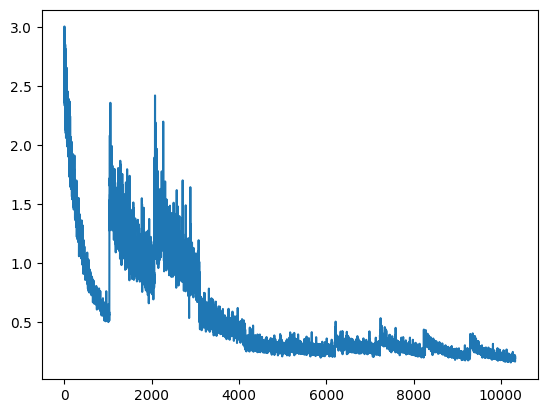

In [30]:
glove = GloveModel(dataset._vocab_len, EMBED_DIM).to(device)
optimizer = optim.Adam(glove.parameters(), lr=0.01)
import matplotlib.pyplot as plt
#training
N_EPOCHS = 10
BATCH_SIZE = 4000
X_MAX = 100
ALPHA = 0.75
n_batches = int(len(dataset._xij) / BATCH_SIZE)
loss_values = list()
for e in range(1, N_EPOCHS+1):
    batch_i = 0

    for x_ij, i_idx, j_idx in dataset.get_batches(BATCH_SIZE):

        batch_i += 1

        optimizer.zero_grad()

        outputs = glove(i_idx, j_idx)
        weights_x = weight_func(x_ij, X_MAX, ALPHA)
        loss = wmse_loss(weights_x, outputs, torch.log(x_ij))

        loss.backward()

        optimizer.step()

        loss_values.append(loss.item())

        if batch_i % 100 == 0:
            print("Epoch: {}/{} \t Batch: {}/{} \t Loss: {}".format(e, N_EPOCHS, batch_i, n_batches, np.mean(loss_values[-20:])))

plt.plot(loss_values)
print("Saving model...")
torch.save(glove.state_dict(), "GloVe.pt")

In [31]:
class EncoderRNN_glove(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(EncoderRNN_glove, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        emb_i = torch.FloatTensor(glove.wi.weight.cpu().data.numpy())
        emb_j = torch.FloatTensor(glove.wj.weight.cpu().data.numpy())
        self.embedding = nn.Embedding.from_pretrained(emb_i + emb_j)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output, hidden = self.lstm(embedded, hidden)
        return output, hidden

    def initHidden(self):
        return (torch.zeros(self.num_layers, 1, self.hidden_size, device=device),
                torch.zeros(self.num_layers, 1, self.hidden_size, device=device))


In [32]:


class AttnDecoderRNN_glove(nn.Module):
    def __init__(self, hidden_size, output_size, num_layers=1, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN_glove, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.dropout_p = dropout_p
        self.max_length = max_length

        # Assume glove.wi and glove.wj are pre-initialized GloVe weights
        emb_i = torch.FloatTensor(glove.wi.weight.cpu().data.numpy())
        emb_j = torch.FloatTensor(glove.wj.weight.cpu().data.numpy())
        self.embedding = nn.Embedding.from_pretrained(emb_i + emb_j)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size, num_layers=self.num_layers)
        self.out = nn.Linear(self.hidden_size, self.output_size)  # Corrected size for final output

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        output, hidden = self.lstm(embedded, hidden)

        # Calculate attention weights from the current LSTM output and encoder outputs
        attn_weights = F.softmax(self.attn(torch.cat((output[0], hidden[0][-1]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

        # Concatenate the attention output with the LSTM output
        output = torch.cat((output[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return (torch.zeros(self.num_layers, 1, self.hidden_size, device=device),
                torch.zeros(self.num_layers, 1, self.hidden_size, device=device))


In [ ]:
hidden_size = 256
num_layers=1
encoder_glove = EncoderRNN_glove(input_ingredients.n_words, hidden_size,num_layers=num_layers).to(device)
attn_decoder_glove = AttnDecoderRNN_glove(hidden_size, output_recipe.n_words, num_layers=num_layers,dropout_p=0.1).to(device)


file_path='/content/drive/MyDrive/Colab Notebooks/checkpoint_attn_glove.pt'
train_losses_attn, val_losses_attn, val_every=trainIters_attn(encoder_glove, attn_decoder_glove, 50000, print_every=1000, validation_pairs=val_pairs, patience=3,file_path=file_path)

2m 58s (- 145m 55s) (1000 2%) Training Loss 5.3481
6m 1s (- 144m 47s) (2000 4%) Training Loss 4.7633
8m 55s (- 139m 43s) (3000 6%) Training Loss 4.5374
11m 42s (- 134m 34s) (4000 8%) Training Loss 4.4886
26m 31s (- 238m 47s) (5000 10%) Training Loss 4.4634 ; Validation Loss: 8.2416
29m 21s (- 215m 21s) (6000 12%) Training Loss 4.4557
32m 14s (- 198m 4s) (7000 14%) Training Loss 4.3982
35m 10s (- 184m 40s) (8000 16%) Training Loss 4.4277
38m 4s (- 173m 28s) (9000 18%) Training Loss 4.3924
52m 47s (- 211m 11s) (10000 20%) Training Loss 4.4403 ; Validation Loss: 8.8474
55m 41s (- 197m 25s) (11000 22%) Training Loss 4.3700
58m 30s (- 185m 17s) (12000 24%) Training Loss 4.4147
61m 23s (- 174m 42s) (13000 26%) Training Loss 4.4397
64m 17s (- 165m 19s) (14000 28%) Training Loss 4.3787
79m 1s (- 184m 22s) (15000 30%) Training Loss 4.4776 ; Validation Loss: 10.6565
81m 52s (- 173m 58s) (16000 32%) Training Loss 4.4456
84m 44s (- 164m 29s) (17000 34%) Training Loss 4.4880
87m 35s (- 155m 42s) (1

In [ ]:
evaluateRandomly_attn(encoder, attn_decoder, save_path='gen_vs_test_seq2seq_withattn_glove.csv')

> 2 c  all purpose flour	1 ts baking powder	1/4 ts salt	2/3 c  sugar	3/4 c  butter	grated rind of 1 lemon	1    egg	milk	1/4 ts almond extract	3 1/2 c  peeled apples, cut in thin wedges
= there are many versions of this one . 
< preheat oven to 350 degrees . add the cream butter and sugar . add the flour , sugar , and flour . add the flour , sugar , and flour . add the cream and sugar . add the flour , sugar , and flour . add the flour , sugar , and flour . add the flour , sugar , and flour . add the flour , sugar , salt and pepper . add the cream and sugar . add the cream and sugar . add the flour , sugar , and flour . add the cream and sugar . add the cream butter and sugar . add the cream and sugar . add the flour and sugar . add the cream butter and sugar . add the flour , sugar , and flour . add the cream and sugar . add the flour , sugar , and flour

> 2 1/2    -3 lb raw jerky meat	2 ts ground oregano	2 ts salt	3/4 c  vinegar directions:	2 lg onions,finely chopped	2    cloves garl

In [126]:
import csv
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score

def read_recipes_from_csv(csv_file):
    reference = []
    generated = []
    with open(csv_file, 'r', newline='', encoding='utf-8') as file:
        reader = csv.DictReader(file)
        for row in reader:
            ref_recipe = row['Test recipe']
            gen_recipe = row['Generated recipe']

            # Check if data is tokenized or not
            if not is_tokenized(ref_recipe):
                ref_recipe = nltk.word_tokenize(ref_recipe)
            if not is_tokenized(gen_recipe):
                gen_recipe = nltk.word_tokenize(gen_recipe)

            reference.append(ref_recipe)
            generated.append(gen_recipe)
    return reference, generated

# Function to check if the recipe is tokenized
def is_tokenized(recipe):
    # If the recipe contains more than one word, it's considered tokenized
    return len(recipe.split()) > 1

# Function to calculate Average Percentage of Given Items (APGI)
def calculate_APGI(reference, output):
    ref_set = set(reference.split())
    out_set = set(output.split())
    common_items = ref_set.intersection(out_set)
    percentage = len(common_items) / len(ref_set) if len(ref_set) > 0 else 0
    return percentage * 100  # Returning percentage

# Function to calculate Average Extra Items (AEI)
def calculate_AEI(reference, output):
    ref_set = set(reference.split())
    out_set = set(output.split())
    extra_items = len(out_set - ref_set)
    return extra_items

# Function to analyze model results
def analyze_model(model_results_csv):
    # Read recipes from CSV
    reference, generated = read_recipes_from_csv(model_results_csv)

    # Lists to store scores
    bleu_scores = []
    meteor_scores = []
    apgi_scores = []
    aei_scores = []

    # Calculate scores
    for ref, out in zip(reference, generated):
        # BLEU-4 and METEOR scores
        bleu = sentence_bleu([ref], out)
        meteor = meteor_score([ref.split()], out.split())

        bleu_scores.append(bleu)
        meteor_scores.append(meteor)

        # APGI and AEI scores
        apgi_scores.append(calculate_APGI(ref, out))
        aei_scores.append(calculate_AEI(ref, out))

    # Print average scores
    print(f"Model {model_results_csv}:")
    print("Average BLEU-4 Score:", sum(bleu_scores) / len(bleu_scores))
    print("Average METEOR Score:", sum(meteor_scores) / len(meteor_scores))
    print("Average APGI Score:", sum(apgi_scores) / len(apgi_scores))
    print("Average AEI Score:", sum(aei_scores) / len(aei_scores))
    print()

# Example usage
analyze_model('/content/drive/MyDrive/gen_vs_test_seq2seq.csv')
analyze_model('/content/drive/MyDrive/Colab Notebooks/gen_vs_test_seq2seq_withattn.csv')
analyze_model('/content/drive/MyDrive/Colab Notebooks/gen_vs_test_seq2seq_layers.csv')
analyze_model('/content/drive/MyDrive/Colab Notebooks/gen_vs_test_seq2seq_glove.csv')


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Model /content/drive/MyDrive/gen_vs_test_seq2seq.csv:
Average BLEU-4 Score: 0.013715390844961118
Average METEOR Score: 0.02003749590228959
Average APGI Score: 3.448337519031381
Average AEI Score: 3.5

Model /content/drive/MyDrive/Colab Notebooks/gen_vs_test_seq2seq_withattn.csv:
Average BLEU-4 Score: 0.11866360589546968
Average METEOR Score: 0.10519134408461579
Average APGI Score: 17.353232496004953
Average AEI Score: 5.5

Model /content/drive/MyDrive/Colab Notebooks/gen_vs_test_seq2seq_layers.csv:
Average BLEU-4 Score: 0.015306021405750622
Average METEOR Score: 0.022706748745534633
Average APGI Score: 6.304319793681495
Average AEI Score: 1.9

Model /content/drive/MyDrive/Colab Notebooks/gen_vs_test_seq2seq_glove.csv:
Average BLEU-4 Score: 0.09802998367791958
Average METEOR Score: 0.07886623696836166
Average APGI Score: 9.66067570268326
Average AEI Score: 6.6

